## Advanced Algorithmic Trading DT - V3

### Updates from Last Version
- Implement PCA
- Do for: 
    - Random Forest
    - Bagging
    - Boosting
    - Linear --> Fix to follow French-Fama Model
- Remove Ridge Regression 

#### Import Packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import datetime
import gc

from sklearn.ensemble import (BaggingRegressor, RandomForestRegressor, AdaBoostRegressor)
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error

from technical_indicators import * # import all function

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
#import parfit as pf
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler




#### Set Parameters

In [2]:
# Set the random seed, number of estimators and the "step factor" used to plot the graph of MSE for each method
random_state = 42  # Seed
n_jobs = -1 # -1 --> all Processors # Parallelisation factor for bagging, random forests (controls the number of processor cores used)
n_estimators = 200 # total number of estimators ot use in the MSE graph
step_factor = 10 # controls cranularity of calculation by stepping through the number of estimators
axis_step = int(n_estimators / step_factor) # 1000/10 = 100 separate calculations will be performed for each of the 3 ensebmle methods


#### Read in Data via GitHub URL

In [3]:
url = "https://raw.githubusercontent.com/meenmo/Stat479_Project/master/Data/IBM.csv"
df_ORIGINAL = pd.read_csv(url)


***
## Clean Data & Create Technical Indicator Variables

- Create Deep copy of dataframe
- Use Adjusted Close Data
- Drop Close 
- Rename "Adj. Close" as "Close"
- Create Lagged Features
- Drop NaN
- Create Technical Indicator Variables
- Drop NaN
- Re-set index as Date

In [4]:
df_features = df_ORIGINAL.copy(deep=True) # Create Deep
df_features.drop(['Close'], axis = 1, inplace = True) # drop close column
df_features.columns = ['Date', 'High', 'Low', 'Open', 'Volume', 'Close'] # Close is actually Adj. Close

df_features['Date'] = pd.to_datetime(df_features['Date'])
#df_features.head() # sanity check


"""
Creates Lagged Returns 
- given OHLCV dataframe
- numer of lagged days
"""
def create_lag_features(df, lag_days):
    df_ret = df.copy()
    
    # iterate through the lag days to generate lag values up to lag_days + 1
    for i in range(1,lag_days + 2):
        df_lag = df_ret[['Date', 'Close']].copy()
        # generate dataframe to shift index by i day.
        df_lag['Date'] = df_lag['Date'].shift(-i)
        df_lag.columns = ['Date', 'value_lag' + str(i)]
        # combine the valuelag
        df_ret = pd.merge(df_ret, df_lag, how = 'left', left_on = ['Date'], right_on = ['Date'])
    
    #frees memory
    del df_lag
    
    # calculate today's percentage lag
    df_ret['Today'] = (df_ret['Close'] - df_ret['value_lag1'])/(df_ret['value_lag1']) * 100.0 
    
    # calculate percentage lag
    for i in range(1, lag_days + 1):
        df_ret['lag' + str(i)] = (df_ret['value_lag'+ str(i)] - df_ret['value_lag'+ str(i+1)])/(df_ret['value_lag'+str(i+1)]) * 100.0
    
    # drop unneeded columns which are value_lags
    for i in range(1, lag_days + 2):
        df_ret.drop(['value_lag' + str(i)], axis = 1, inplace = True)
                                                                                                                                                                                                                                                                                                                                     
    return df_ret


### Run Function
df_features = create_lag_features(df_features, 5) # 5 lag features
#df_features.head(7)

# drop earlier data with missing lag features
df_features.dropna(inplace=True)
# reset index
df_features.reset_index(drop = True, inplace = True)


#### GENERATE TECHNICAL INDICATORS FEATURES
df_features = standard_deviation(df_features, 14)

df_features = relative_strength_index(df_features, 14) # periods
df_features = average_directional_movement_index(df_features, 14, 13) # n, n_ADX
df_features = moving_average(df_features, 21) # periods
df_features = exponential_moving_average(df_features, 21) # periods
df_features = momentum(df_features, 14) # 

df_features = average_true_range(df_features, 14)
df_features = bollinger_bands(df_features, 21)
df_features = ppsr(df_features)
df_features = stochastic_oscillator_k(df_features)
df_features = stochastic_oscillator_d(df_features, 14)
df_features = trix(df_features, 14)
df_features = macd(df_features, 26, 12)
df_features = mass_index(df_features)
df_features = vortex_indicator(df_features, 14)

df_features = kst_oscillator(df_features, 10, 10, 10, 15, 10, 15, 20, 30)
df_features = true_strength_index(df_features, 25, 13)

#df_features = accumulation_distribution(df_features, 14) # Causes Problems, apparently
df_features = chaikin_oscillator(df_features)
df_features = money_flow_index(df_features, 14)
df_features = on_balance_volume(df_features, 14)
df_features = force_index(df_features, 14)
df_features = ease_of_movement(df_features, 14)
df_features = commodity_channel_index(df_features, 14)
df_features = keltner_channel(df_features, 14)
df_features = ultimate_oscillator(df_features)
df_features = donchian_channel(df_features, 14)
    
# drop earlier data with missing lag features
df_features.dropna(inplace=True)
df_features = df_features.reset_index(drop = True)



###########################################################################################
# Store Variables now for plots later
daily_index = df_features.index
daily_returns = df_features["Today"]
daily_price   = df_features["Close"]

# Re-set "Date" as the index
df_features = df_features.set_index('Date')

### Sanity Check
df_features.head(10)


,High,Low,Open,Volume,Close,Today,lag1,lag2,lag3,lag4,...,MFI_14,OBV_14,Force_14,EoM_14,CCI_14,KelChM_14,KelChU_14,KelChD_14,Ultimate_Osc,Donchian_14
Date,,,,,,,,,,,,,,,,,,,,,
2002-03-14,107.949997,106.589996,107.019997,5335500,74.391068,-0.541176,-1.216580,3.097695,0.142742,1.330632,...,0.714286,1.962464e+06,-2.921157e+07,2.286739e-07,0.959960,93.032764,95.832764,90.232765,0.034641,13.389999
2002-03-15,107.449997,105.589996,106.550003,10864100,74.523666,0.178246,-0.541176,-1.216580,3.097695,0.142742,...,0.642857,3.445814e+06,5.695471e+06,2.086708e-07,0.713277,93.570735,96.351449,90.790020,0.031385,13.389999
2002-03-18,108.639999,106.230003,107.099999,5301200,74.216637,-0.411990,0.178246,-0.541176,-1.216580,3.097695,...,0.714286,3.898193e+06,-4.066156e+07,2.500726e-07,0.779588,94.192408,96.916693,91.468123,0.058735,13.389999
2002-03-19,108.050003,106.489998,106.849999,4614800,75.012154,1.071885,-0.411990,0.178246,-0.541176,-1.216580,...,0.714286,3.372200e+06,-4.964177e+07,2.263920e-07,0.762796,94.770295,97.348152,92.192438,0.057835,13.389999
2002-03-20,106.900001,105.489998,106.900001,4844100,73.623466,-1.851283,1.071885,-0.411990,0.178246,-0.541176,...,0.642857,2.459121e+06,-1.593928e+07,2.007584e-07,0.060704,95.249347,97.800775,92.697918,0.026201,13.389999
2002-03-21,106.779999,104.699997,105.699997,5113100,74.516685,1.213226,-1.851283,1.071885,-0.411990,0.178246,...,0.571429,2.074850e+06,-1.411611e+07,1.220918e-07,-0.248791,95.547059,97.918488,93.175630,-0.008129,13.389999
2002-03-22,106.699997,105.070000,106.500000,5507900,73.693192,-1.105114,1.213226,-1.851283,1.071885,-0.411990,...,0.500000,9.123071e+05,1.101343e+06,3.426329e-08,-0.533297,95.592311,97.837311,93.347311,-0.021320,13.389999
2002-03-25,106.660004,103.500000,105.800003,6277900,72.269615,-1.931761,-1.105114,1.213226,-1.851283,1.071885,...,0.428571,1.004036e+06,1.890940e+06,-5.730833e-09,-1.582313,95.545348,97.848920,93.241776,-0.045311,13.389999
2002-03-26,105.699997,102.300003,103.570000,8144000,71.809052,-0.637285,-1.931761,-1.105114,1.213226,-1.851283,...,0.357143,-1.267786e+05,-1.083363e+06,-5.076478e-08,-1.978289,95.397427,97.776713,93.018141,-0.061006,11.739998


## PCA & Create X & y

- Drop all data used to create technical indicators (this is done in the book)
- Then Standardize, necessary for PCA
- Run PCA
- Select Appropriate number of components
- Create X & y

NOTE: some technical indicators use Present  data, but for simplicity, just ignore this

In [70]:

### Standardize Data
##########################################################################################
# Drop Columns
list_of_columns_to_exclude = ["High", "Low", "Open", "Volume","Close", "Today"]
X_temp_standardized = df_features.copy(deep=True)
X_temp_standardized.drop(list_of_columns_to_exclude, axis = 1, inplace = True) # drop columns

# Standardize
X_temp_standardized
dates = X_temp_standardized.index # get dates to set as index after data is standardized
names = X_temp_standardized.columns # Get column names first
X_temp_standardized = StandardScaler().fit_transform(X_temp_standardized)

# Convert to DataFrame
X_temp_standardized = pd.DataFrame(X_temp_standardized, columns=names, index=dates)


### PCA
##########################################################################################
# Fit PCA
pca_all = PCA().fit(X_temp_standardized)

# Count number of components to retain
count = 0
for var in pca_all.explained_variance_.round(4):
    if var >= 1:
        count += 1

# # Sanity Check
# np.set_printoptions(suppress=True) # Stop scientifit notation
# print(pca_all.explained_variance_.round(4)[0:10])
# print(count)

# # Scree plot
# plt.figure(figsize=(15, 8))
# plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
# plt.plot((pca_all.explained_variance_ratio_))
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Explained Variance');
# plt.title('Scree Plot -- X_one_standardized')


### Transform Data & Select only PCs/Columns up to count 
##########################################################################################
def create_column_names(numColumns):
    colNames = []
    for i in range(numColumns):
        tempName = "PC" + str(i+1)
        colNames.append(tempName)
    return colNames

X = pca_all.transform(X_temp_standardized)
X = pd.DataFrame(X, columns=create_column_names(X.shape[1]), index=dates)
X = X.iloc[:,:count]


### Get y
##########################################################################################
y_temp = pd.DataFrame(df_features["Today"], index=X.index) # can only standardize a dataframe
y = StandardScaler().fit_transform(y_temp) # Standardize, cause we did it for our original variables
y = pd.DataFrame(y, index=X.index, columns=["Today"]) # convert back to dataframe
y = y["Today"] # now re-get y as a Pandas Series

### Sanity Check
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

# Check Types
print(type(X)) # Needs to be <class 'pandas.core.frame.DataFrame'>
print(type(y)) # Needs ro be <class 'pandas.core.series.Series'>



Shape of X:  (4190, 9)
Shape of y:  (4190,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


#### Split: Train & Validatte / Test

- Train & Validate: < '2018-01-01'
- Test: >= '2018-01-01'

In [75]:

X_train_all = X.loc[(X.index < '2018-01-01')]
y_train_all = y[X_train_all.index]

# # creates all test data which is all after January 2018
X_test = X.loc[(X.index >= '2018-01-01'),:]
y_test = y[X_test.index]

### Sanity Check
print("Shape of X_train_all: ", X_train_all.shape)
print("Shape of y_train_all: ", y_train_all.shape)
print("Shape of X_test:      ", X_test.shape)
print("Shape of y_test:      ", y_test.shape)




Shape of X_train_all:  (3979, 9)
Shape of y_train_all:  (3979,)
Shape of X_test:       (211, 9)
Shape of y_test:       (211,)


## Time Series Train Test Split ---- 


### Random Forest

In [81]:
"""
Execute Random Forest for differnt number of Time Series Splits
- I turned this code into a function to that's it's easy call may times and compare the
        graphs between different split
"""
def Call_Random_Forest(numSplits):
    ### Prepare Random Forest
    ##############################################################################
    # Initialize Random Forest Instance
    rf = RandomForestRegressor(n_estimators=150, n_jobs=-1, random_state=123)

    rf_mse = [] # MSE
    rf_r2 = [] # R2


    ### Time Series Split
    ##############################################################################
    splits = TimeSeriesSplit(n_splits=numSplits) # 3 splits

    splitCount = 0 # dummy count var to track current split num in print statements
    for train_index, test_index in splits.split(X_train_all):
        splitCount += 1 

        # Train Split
        X_train = X_train_all.iloc[0:len(train_index) - 1,:].copy(deep=True)
        y_train = y[X_train.index]

        # Validate Split
        X_val = X_train_all.iloc[len(train_index) - 1:,:].copy(deep=True)
        y_val = y[X_val.index]

#         # Print Statements
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         print("Split: ", splitCount)
#         print('Observations: ', (X_train.shape[0] + X_test.shape[0]))
#         #print('Cutoff date, or first date in validation data: ', X_val.iloc[0,0])
#         print('Training Observations: ', (X_train.shape[0]))
#         print('Testing Observations: ', (X_test.shape[0]))
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        ### Run Random Forest
        rf.fit(X_train, y_train)
        prediction = rf.predict(X_val)

        mse = mean_squared_error(y_val, prediction)
        r2  = r2_score(y_val, prediction)

        rf_mse.append(mse)
        rf_r2.append(r2)

    # print("rf_mse: ", rf_mse)
    # print("rf_r2: ", rf_r2)



    ### Time Series Split
    ##############################################################################
    # Plot the chart of MSE versus number of estimators
    plt.figure(figsize=(12, 7))
    plt.title('Random Forest - MSE & R-Squared')

    ### MSE
    plt.plot(list(range(1,splitCount+1)), rf_mse, 'b-', color="blue", label='MSE')
    plt.plot(list(range(1,splitCount+1)), rf_r2, 'b-', color="green", label='R-Squared')
    plt.plot(list(range(1,splitCount+1)), np.array([0] * splitCount), 'b-', color="red", label='Zero')


    plt.legend(loc='upper right')
    plt.xlabel('Train/Test Split Number')
    plt.ylabel('Mean Squared Error & R-Squared')
    plt.show()


### Bagging

In [77]:
"""
Execute Bagging for differnt number of Time Series Splits
- I turned this code into a function to that's it's easy call may times and compare the
        graphs between different split
"""
def Call_Bagging(numSplits):
    ### Prepare Bagging
    ##############################################################################
    # Initialize Bagging Instance
    bagging = BaggingRegressor(n_estimators=150, n_jobs=-1, random_state=123)

    bagging_mse = [] # MSE
    bagging_r2 = [] # R2


    ### Time Series Split
    ##############################################################################
    splits = TimeSeriesSplit(n_splits=numSplits) # 3 splits

    splitCount = 0 # dummy count var to track current split num in print statements
    for train_index, test_index in splits.split(X_train_all):
        splitCount += 1 

        # Train Split
        X_train = X_train_all.iloc[0:len(train_index) - 1,:].copy(deep=True)
        y_train = y[X_train.index]

        # Validate Split
        X_val = X_train_all.iloc[len(train_index) - 1:,:].copy(deep=True)
        y_val = y[X_val.index]

#         # Print Statements
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         print("Split: ", splitCount)
#         print('Observations: ', (X_train.shape[0] + X_test.shape[0]))
#         #print('Cutoff date, or first date in validation data: ', X_val.iloc[0,0])
#         print('Training Observations: ', (X_train.shape[0]))
#         print('Testing Observations: ', (X_test.shape[0]))
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        ### Run Random Forest
        bagging.fit(X_train, y_train)
        prediction = bagging.predict(X_val)

        mse = mean_squared_error(y_val, prediction)
        r2  = r2_score(y_val, prediction)

        bagging_mse.append(mse)
        bagging_r2.append(r2)


    ### Time Series Split
    ##############################################################################
    # Plot the chart of MSE versus number of estimators
    plt.figure(figsize=(12, 7))
    plt.title('Bagging - MSE & R-Squared')

    ### MSE
    plt.plot(list(range(1,splitCount+1)), bagging_mse, 'b-', color="blue", label='MSE')
    plt.plot(list(range(1,splitCount+1)), bagging_r2, 'b-', color="green", label='R-Squared')
    plt.plot(list(range(1,splitCount+1)), np.array([0] * splitCount), 'b-', color="red", label='Zero')


    plt.legend(loc='upper right')
    plt.xlabel('Train/Test Split Number')
    plt.ylabel('Mean Squared Error & R-Squared')
    plt.show()



### Boosting

In [78]:
"""
Execute Random Forest for differnt number of Time Series Splits
- I turned this code into a function to that's it's easy call may times and compare the
        graphs between different split
"""
def Call_Boosting(numSplits):
    ### Prepare Boosting
    ##############################################################################
    # Initialize Boosting Instance    
    boosting = AdaBoostRegressor(DecisionTreeRegressor(),
                                 n_estimators=150, random_state=123,learning_rate=0.01)

    boosting_mse = [] # MSE
    boosting_r2 = [] # R2


    ### Time Series Split
    ##############################################################################
    splits = TimeSeriesSplit(n_splits=numSplits) # 3 splits

    splitCount = 0 # dummy count var to track current split num in print statements
    for train_index, test_index in splits.split(X_train_all):
        splitCount += 1 

        # Train Split
        X_train = X_train_all.iloc[0:len(train_index) - 1,:].copy(deep=True)
        y_train = y[X_train.index]

        # Validate Split
        X_val = X_train_all.iloc[len(train_index) - 1:,:].copy(deep=True)
        y_val = y[X_val.index]

#         # Print Statements
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         print("Split: ", splitCount)
#         print('Observations: ', (X_train.shape[0] + X_test.shape[0]))
#         #print('Cutoff date, or first date in validation data: ', X_val.iloc[0,0])
#         print('Training Observations: ', (X_train.shape[0]))
#         print('Testing Observations: ', (X_test.shape[0]))
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        ### Run Random Forest
        boosting.fit(X_train, y_train)
        prediction = boosting.predict(X_val)

        mse = mean_squared_error(y_val, prediction)
        r2  = r2_score(y_val, prediction)

        boosting_mse.append(mse)
        boosting_r2.append(r2)


    ### Time Series Split
    ##############################################################################
    # Plot the chart of MSE versus number of estimators
    plt.figure(figsize=(12, 7))
    plt.title('Boosting - MSE & R-Squared')

    ### MSE
    plt.plot(list(range(1,splitCount+1)), boosting_mse, 'b-', color="blue", label='MSE')
    plt.plot(list(range(1,splitCount+1)), boosting_r2, 'b-', color="green", label='R-Squared')
    plt.plot(list(range(1,splitCount+1)), np.array([0] * splitCount), 'b-', color="red", label='Zero')


    plt.legend(loc='upper right')
    plt.xlabel('Train/Test Split Number')
    plt.ylabel('Mean Squared Error & R-Squared')
    plt.show()



### Linear Regression - French Fama 3 Factor Model

#### NOTE: For Random Forests, 150 Estimators seems optimal. 

- The optimal number of estimators for random forests & bagging is actually arround 400 but this seems a little too large, since we're not running supercomputers. So for computaional purposes 150 surves us better.
- Using Adjusted Close prices --> decreases our MSE & increases our R2
- Using more features than just Lagged returns --> decreases our MSE & increases our R2


##### Random Forest
- Optimal: __150 Estimators__

##### Bagging
- Optimal: __150 Estimators__

##### Boosting
- Optimal: __150 Estimators__
- Note the when only Lag features are used, the optimal number of estimators is around 50 and is in a U shape, but when more features are included out MSE become monotone decreasing 



#### Misc. Graphs

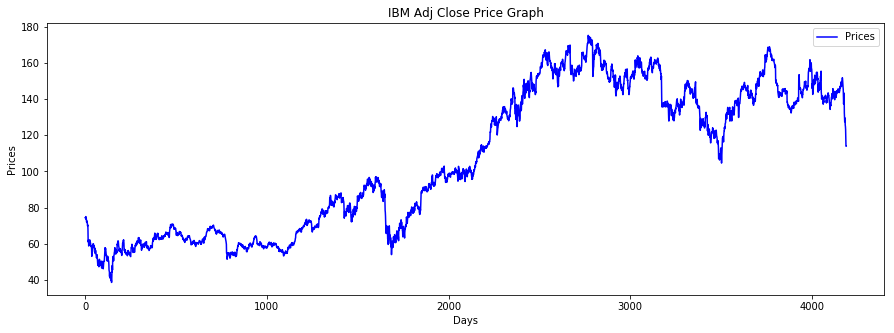

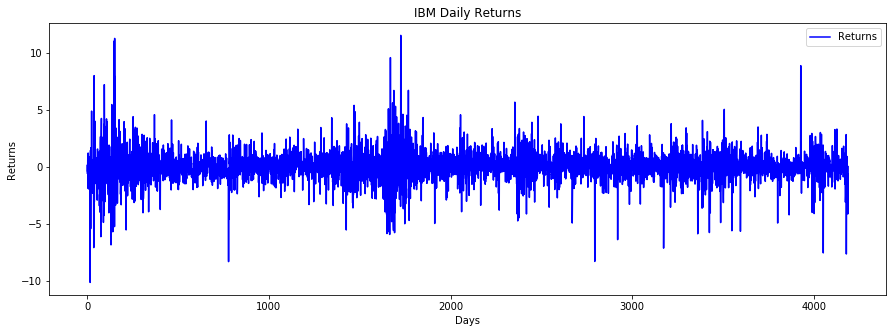

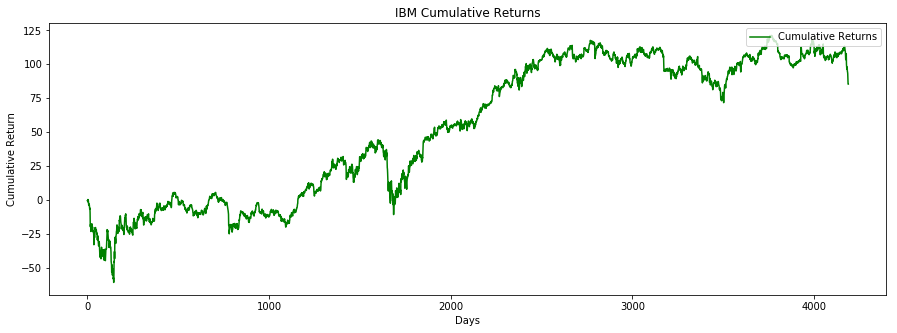

In [67]:
# figure dimenstions
length = 15
height = 5

### Prices
plt.figure(figsize=(length, height))
plt.title('IBM Adj Close Price Graph')
plt.plot(daily_index, daily_price, 'b-', color="blue", label='Prices')
plt.legend(loc='upper right')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.show()

### Returns
plt.figure(figsize=(length, height))
plt.title('IBM Daily Returns')
plt.plot(daily_index, daily_returns, 'b-', color="blue", label='Returns')
plt.legend(loc='upper right')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.show()

### Cumulative Returns
plt.figure(figsize=(length, height))
plt.title('IBM Cumulative Returns')
cumulative_returns = daily_returns.cumsum()
plt.plot(daily_index, cumulative_returns, 'b-', color="green", label='Cumulative Returns')
plt.legend(loc='upper right')
plt.xlabel('Days')
plt.ylabel('Cumulative Return')
plt.show()


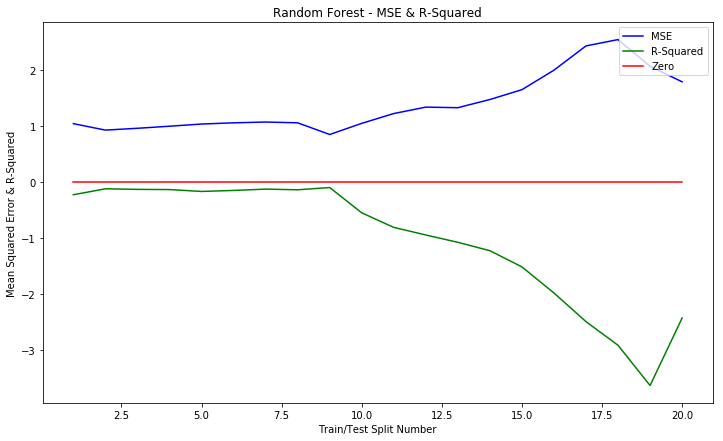

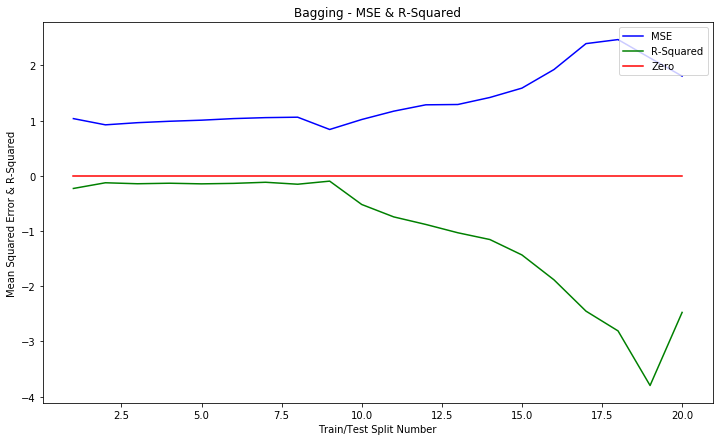

In [83]:
Call_Random_Forest(20) 
Call_Bagging(20) 
# Call_Boosting(20) # takes forever to run

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Split:  1
Observations:  289
Training Observations:  78
Testing Observations:  211
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Split:  2
Observations:  328
Training Observations:  117
Testing Observations:  211
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Split:  3
Observations:  367
Training Observations:  156
Testing Observations:  211
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Split:  4
Observations:  406
Training Observations:  195
Testing Observations:  211
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Split:  5
Observations:  4

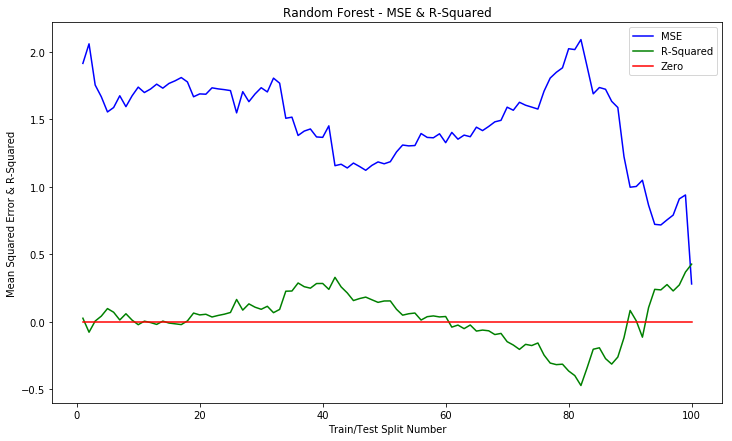

In [147]:
# Call_Random_Forest(100) # see how it performs for a very large number of splits


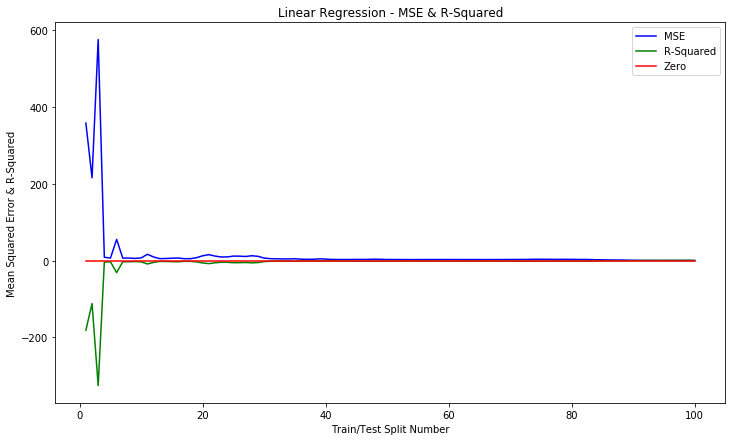

In [172]:
Call_Linear(100)